In [ ]:
# All CIFAR experiments in the Confident Learning paper.

### Benchmark test@1 accuracies for non-cl methods in the were implemented at Google using the internal codebase and are not un

In [1]:
import numpy as np
import cleanlab
from cleanlab import baseline_methods
from cleanlab.latent_estimation import compute_confident_joint
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import pandas as pd
import os
import sys
import json

import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
font = {'family': 'sans-serif',
        'sans-serif':['Helvetica'],
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [2]:
noisy_base_dir = '/home/cgn/cgn/cleanlab/examples/cifar/cifar10/'
base_dir = noisy_base_dir # '/home/cgn/OLD_BAD_cifar10/'

In [3]:
rfn = '/datasets/datasets/cifar10/cifar10/train_filename2label.json'
with open(rfn, 'r') as rf:
    d = json.load(rf)
y = np.asarray([v for k,v in d.items()])

In [14]:
# This code assumes that the `cifar10/cifar

folders = [c for c in os.listdir(base_dir) if '__' in c]
results = []
for folder in sorted([f for f in folders if f != '__pycache__']):
    print(folder)
    psx_file = [z for z in os.listdir(base_dir + folder) if 'pyx' in z][0]
    psx = np.load(base_dir + folder + "/" + psx_file)
    
    #Make sure psx is the right shape
    psx = psx[:,:10]
    
    # Load noisy labels
    frac_zero_noise_rates = folder.split('_')[-7]
    noise_amount = folder.split('_')[-1]
    if noise_amount == '8':
        continue
    rfn = 'cifar10_noisy_labels__frac_zero_noise_rates__0.{}__noise_amount__0.{}.json'.format(
        frac_zero_noise_rates, noise_amount)
    with open(noisy_base_dir + "cifar10_noisy_labels/" + rfn, 'r') as rf:
        d = json.load(rf)
    s = np.asarray([v for k,v in d.items()])
    
    true_label_errors = s != y
    acc = np.sum(s == y) / len(y)
    print('accuracy of labels:', acc)

    # Benchmarks
    
    label_error_mask = np.zeros(len(s), dtype=bool)
    label_error_indices = compute_confident_joint(
        s, psx, return_indices_of_off_diagonals=True
    )[1]
    for idx in label_error_indices:
        label_error_mask[idx] = True
    conf_joint_only = label_error_mask

#     # Confident learning optimized
#     best_f1 = -1
#     cl_opt = None
#     for prune_method in ['prune_by_class', 'prune_by_noise_rate', 'both']:
#         label_errs = cleanlab.pruning.get_noise_indices(
#             s,
#             psx,
#             prune_method=prune_method,
#         )
#         f1 = precision_recall_fscore_support(
#             y_true=true_label_errors,
#             y_pred=label_errs,
#         )[2][0]

#         if f1 > best_f1:
#             print(prune_method)
#             best_f1 = f1
#             cl_opt = label_errs

    results.append({
        'noise_amount_acc': acc,
        'noise_amount': noise_amount,
        'frac_zero_noise_rates': frac_zero_noise_rates,
        'argmax' : confusion_matrix(
            y_true=true_label_errors,
            y_pred=baseline_methods.baseline_argmax(psx, s),
        ),
        'argmax_cm': confusion_matrix(
            y_true=true_label_errors,
            y_pred=baseline_methods.baseline_argmax_confusion_matrix(psx, s),
        ),
        'argmax_ccm': confusion_matrix(
            y_true=true_label_errors,
            y_pred=baseline_methods.baseline_argmax_calibrated_confusion_matrix(
                psx, s),
        ),
        'conf_joint_only': confusion_matrix(
            y_true=true_label_errors,
            y_pred=conf_joint_only,
        ),
        'cl_pbnr': confusion_matrix(
            y_true=true_label_errors,
            y_pred=cleanlab.pruning.get_noise_indices(s, psx),
        ),
        'cl_pbc': confusion_matrix(
            y_true=true_label_errors,
            y_pred=cleanlab.pruning.get_noise_indices(
                s, psx, prune_method='prune_by_class'),
        ),
        'cl_both': confusion_matrix(
            y_true=true_label_errors,
            y_pred=cleanlab.pruning.get_noise_indices(
                s, psx, prune_method='both'),
        ),
#         'cl_opt': confusion_matrix(
#             y_true=true_label_errors,
#             y_pred=label_errs,
#         ),
    })
    
    print()

cifar10_noisy_labels__frac_zero_noise_rates__0_0__noise_amount__0_0
accuracy of labels: 1.0

cifar10_noisy_labels__frac_zero_noise_rates__0_0__noise_amount__0_2
accuracy of labels: 0.80086

cifar10_noisy_labels__frac_zero_noise_rates__0_0__noise_amount__0_4
accuracy of labels: 0.60092

cifar10_noisy_labels__frac_zero_noise_rates__0_0__noise_amount__0_6
accuracy of labels: 0.30088

cifar10_noisy_labels__frac_zero_noise_rates__0_0__noise_amount__0_8
cifar10_noisy_labels__frac_zero_noise_rates__0_2__noise_amount__0_2
accuracy of labels: 0.80068

cifar10_noisy_labels__frac_zero_noise_rates__0_2__noise_amount__0_4
accuracy of labels: 0.60066

cifar10_noisy_labels__frac_zero_noise_rates__0_2__noise_amount__0_6
accuracy of labels: 0.30082

cifar10_noisy_labels__frac_zero_noise_rates__0_2__noise_amount__0_8
cifar10_noisy_labels__frac_zero_noise_rates__0_4__noise_amount__0_2
accuracy of labels: 0.80054

cifar10_noisy_labels__frac_zero_noise_rates__0_4__noise_amount__0_4
accuracy of labels: 0.60

In [15]:
methods = ['argmax', 'argmax_ccm', 'argmax_cm', 'cl_pbnr', 'cl_pbc', 'cl_both', 'conf_joint_only']
precision_func = lambda x: x[1][1] * 1.0 / (x[1][1] + x[0][1])
recall_func = lambda x: x[1][1] * 1.0 / (x[1][1] + x[1][0])
acc_func = lambda x: (x[1][1] + x[0][0]) * 1.0 / (x[1][1] + x[1][0] + x[0][1] + x[0][0])
f1_func = lambda x: 2 * precision_func(x) * recall_func(x) / \
    (precision_func(x) + recall_func(x))
scoring = {
    'precision': precision_func,
    'recall': recall_func,
    'f1': f1_func,
    'acc': acc_func
}

# Create pandas dataframe to view results
df = pd.DataFrame(results)
df['label_error_fraction'] = np.round(1 - df['noise_amount_acc'], 1)

# For each baseline method, apply each scoring method
for method in methods:
    for k, v in scoring.items():
        df[method + "_" + k] = df[method].apply(v)

In [16]:
if type(df['frac_zero_noise_rates'].iloc[0]) is str:
    df['frac_zero_noise_rates'] = df['frac_zero_noise_rates'].apply(
        lambda x: int(x) / 10.)
if type(df['noise_amount'].iloc[0]) is str:
    df['noise_amount'] = df['noise_amount'].apply(
        lambda x: int(x) / 10.)

In [100]:
a = df[(df['frac_zero_noise_rates']!=.4) & (df['frac_zero_noise_rates']!=.2) & (df['label_error_fraction'] != 0)].groupby(['label_error_fraction', 'frac_zero_noise_rates']).mean()[['argmax_acc', 'cl_pbc_acc', 'cl_pbnr_acc', 'cl_both_acc', 'conf_joint_only_acc']].T.round(2)
a

label_error_fraction    0.2         0.4         0.7      
frac_zero_noise_rates   0.0   0.6   0.0   0.6   0.0   0.6
argmax_acc             0.84  0.85  0.85  0.81  0.76  0.61
cl_pbc_acc             0.88  0.88  0.86  0.82  0.73  0.59
cl_pbnr_acc            0.89  0.90  0.88  0.84  0.66  0.54
cl_both_acc            0.90  0.90  0.87  0.83  0.64  0.53
conf_joint_only_acc    0.89  0.90  0.86  0.84  0.76  0.60

In [101]:
b = df[(df['frac_zero_noise_rates']!=.4) & (df['frac_zero_noise_rates']!=.2) & (df['label_error_fraction'] != 0)].groupby(['label_error_fraction', 'frac_zero_noise_rates']).mean()[['argmax_f1', 'cl_pbc_f1', 'cl_pbnr_f1', 'cl_both_f1', 'conf_joint_only_f1']].T.round(2)
b

label_error_fraction    0.2         0.4         0.7      
frac_zero_noise_rates   0.0   0.6   0.0   0.6   0.0   0.6
argmax_f1              0.71  0.72  0.84  0.79  0.83  0.70
cl_pbc_f1              0.76  0.76  0.84  0.79  0.81  0.67
cl_pbnr_f1             0.77  0.79  0.85  0.80  0.72  0.60
cl_both_f1             0.78  0.78  0.84  0.78  0.70  0.58
conf_joint_only_f1     0.75  0.78  0.84  0.80  0.83  0.69

In [102]:
c = df[(df['frac_zero_noise_rates']!=.4) & (df['frac_zero_noise_rates']!=.2) & (df['label_error_fraction'] != 0)].groupby(['label_error_fraction', 'frac_zero_noise_rates']).mean()[['argmax_precision', 'cl_pbc_precision', 'cl_pbnr_precision', 'cl_both_precision', 'conf_joint_only_precision']].T.round(2)
c

label_error_fraction        0.2         0.4         0.7      
frac_zero_noise_rates       0.0   0.6   0.0   0.6   0.0   0.6
argmax_precision           0.56  0.58  0.74  0.70  0.82  0.76
cl_pbc_precision           0.64  0.65  0.76  0.74  0.82  0.76
cl_pbnr_precision          0.65  0.68  0.82  0.79  0.84  0.77
cl_both_precision          0.67  0.69  0.82  0.79  0.84  0.77
conf_joint_only_precision  0.67  0.70  0.78  0.77  0.82  0.76

In [103]:
d = df[(df['frac_zero_noise_rates']!=.4) & (df['frac_zero_noise_rates']!=.2) & (df['label_error_fraction'] != 0)].groupby(['label_error_fraction', 'frac_zero_noise_rates']).mean()[['argmax_recall', 'cl_pbc_recall', 'cl_pbnr_recall', 'cl_both_recall', 'conf_joint_only_recall']].T.round(2)
d

label_error_fraction     0.2         0.4         0.7      
frac_zero_noise_rates    0.0   0.6   0.0   0.6   0.0   0.6
argmax_recall           0.98  0.97  0.97  0.90  0.84  0.65
cl_pbc_recall           0.96  0.93  0.94  0.85  0.80  0.61
cl_pbnr_recall          0.93  0.94  0.88  0.82  0.63  0.49
cl_both_recall          0.93  0.90  0.87  0.78  0.61  0.47
conf_joint_only_recall  0.86  0.88  0.91  0.84  0.84  0.63

In [109]:
for z in [a,b,c,d]:
    print(z.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
label\_error\_fraction & \multicolumn{2}{l}{0.2} & \multicolumn{2}{l}{0.4} & \multicolumn{2}{l}{0.7} \\
frac\_zero\_noise\_rates &   0.0 &   0.6 &   0.0 &   0.6 &   0.0 &   0.6 \\
\midrule
argmax\_acc          &  0.84 &  0.85 &  0.85 &  0.81 &  0.76 &  0.61 \\
cl\_pbc\_acc          &  0.88 &  0.88 &  0.86 &  0.82 &  0.73 &  0.59 \\
cl\_pbnr\_acc         &  0.89 &  0.90 &  0.88 &  0.84 &  0.66 &  0.54 \\
cl\_both\_acc         &  0.90 &  0.90 &  0.87 &  0.83 &  0.64 &  0.53 \\
conf\_joint\_only\_acc &  0.89 &  0.90 &  0.86 &  0.84 &  0.76 &  0.60 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrr}
\toprule
label\_error\_fraction & \multicolumn{2}{l}{0.2} & \multicolumn{2}{l}{0.4} & \multicolumn{2}{l}{0.7} \\
frac\_zero\_noise\_rates &   0.0 &   0.6 &   0.0 &   0.6 &   0.0 &   0.6 \\
\midrule
argmax\_f1          &  0.71 &  0.72 &  0.84 &  0.79 &  0.83 &  0.70 \\
cl\_pbc\_f1          &  0.76 &  0.76 &  0.84 &  0.79 &  0.81 &  0.67 \\
cl\_pbnr\_f1       


frac_zero_noise_rates: 0


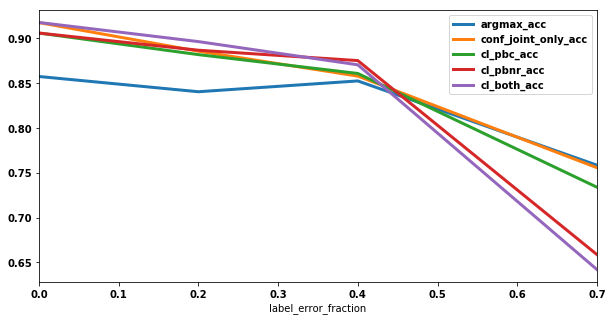


frac_zero_noise_rates: 0.2


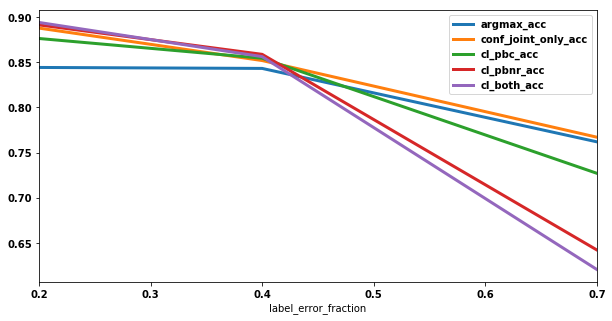


frac_zero_noise_rates: 0.4


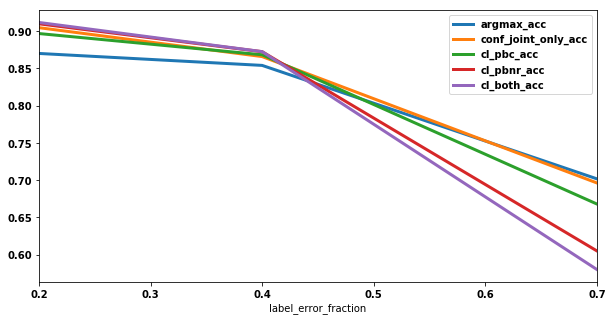


frac_zero_noise_rates: 0.6


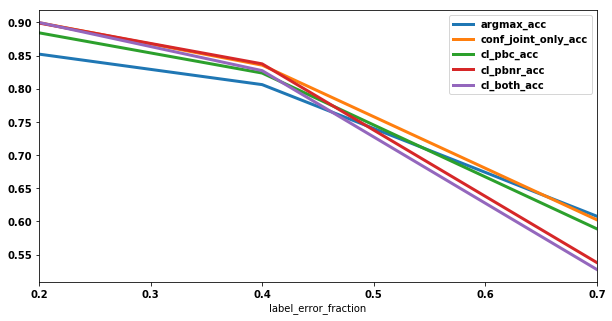

In [23]:
# df['noise'] = (1 - df['noise_amount_acc']).round(1)

columns = ['argmax', 'conf_joint_only', 'cl_pbc', 'cl_pbnr', 'cl_both'] # , 'argmax_cm', 'argmax_ccm', 'cl_pbnr', 'cl_both'

for frac_zero_noise_rates in [0, 0.2, 0.4, 0.6]:
    
    print("\nfrac_zero_noise_rates:", frac_zero_noise_rates)
    sys.stdout.flush()
    
#     df[np.abs(df['frac_zero_noise_rates'] - frac_zero_noise_rates) < 1e-3].sort_values(by='label_error_fraction').set_index('label_error_fraction')[[c + "_precision" for c in columns]].plot(
#         figsize=(20,5), linewidth=3)

#     df[np.abs(df['frac_zero_noise_rates'] - frac_zero_noise_rates) < 1e-3].sort_values(by='label_error_fraction').set_index('label_error_fraction')[[c + "_recall" for c in columns]].plot(
#         figsize=(20,5), linewidth=3)

#     df[np.abs(df['frac_zero_noise_rates'] - frac_zero_noise_rates) < 1e-3].sort_values(by='label_error_fraction').set_index('label_error_fraction')[[c + "_f1" for c in columns]].plot(
#         figsize=(20,5), linewidth=3)

    df[np.abs(df['frac_zero_noise_rates'] - frac_zero_noise_rates) < 1e-3].sort_values(by='label_error_fraction').set_index('label_error_fraction')[[c + "_acc" for c in columns if 'amount' not in c]].plot(
        figsize=(10,5), linewidth=3)
    
    plt.show()

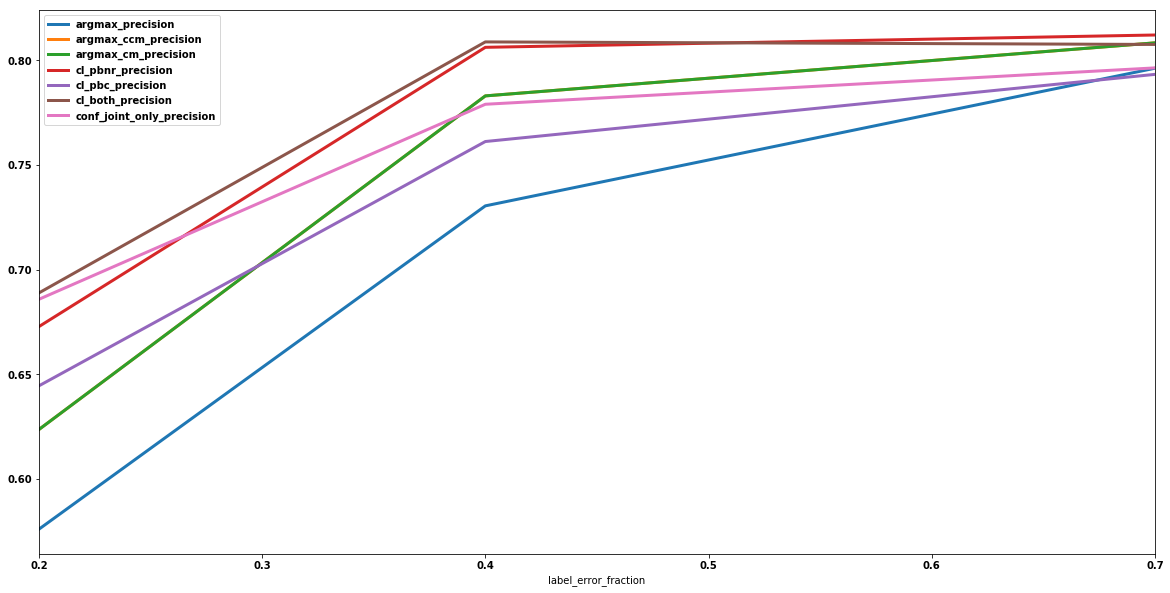

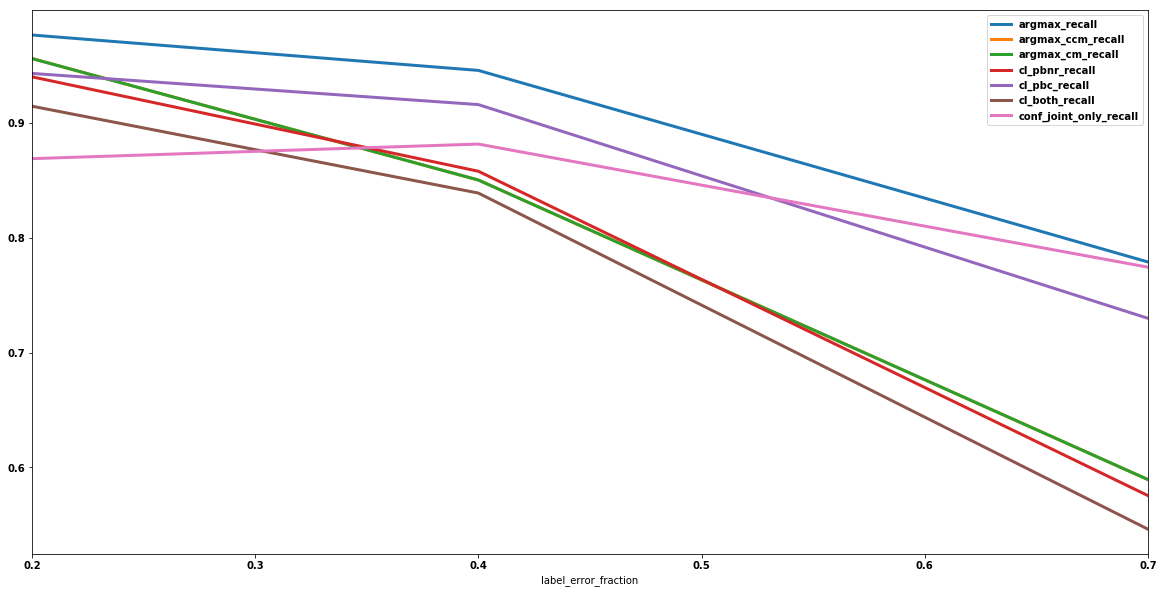

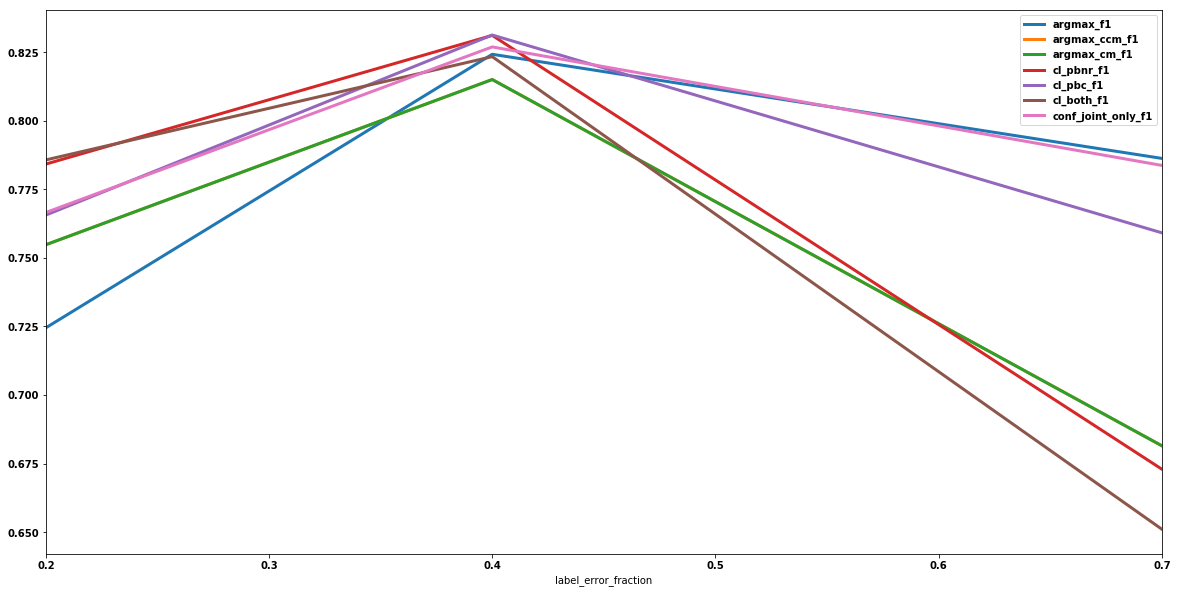

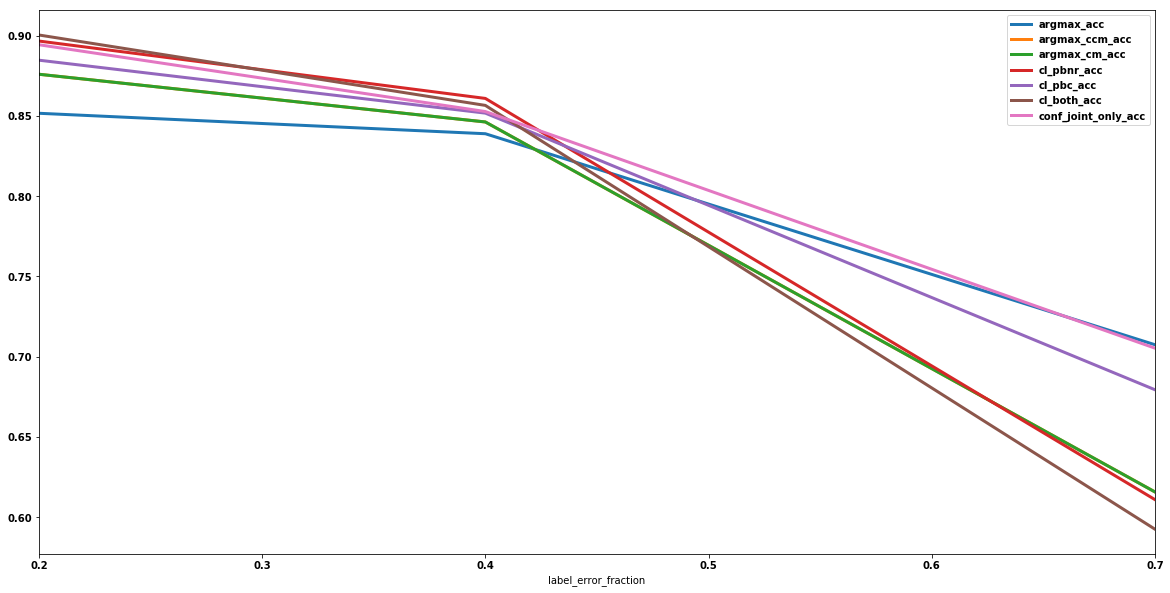

In [22]:
# df['noise'] = (1 - df['noise_amount_acc']).round(1)
    
df[df['label_error_fraction'] > 0].groupby('label_error_fraction').mean()[[c for c in df.columns if 'precision' in c]].plot(
    figsize=(20,10), linewidth=3)

df[df['label_error_fraction'] > 0].groupby('label_error_fraction').mean()[[c for c in df.columns if 'recall' in c]].plot(
    figsize=(20,10), linewidth=3)

df[df['label_error_fraction'] > 0].groupby('label_error_fraction').mean()[[c for c in df.columns if 'f1' in c]].plot(
    figsize=(20,10), linewidth=3)

df[df['label_error_fraction'] > 0].groupby('label_error_fraction').mean()[[c for c in df.columns if 'acc' in c and 'amount' not in c]].plot(
    figsize=(20,10), linewidth=3)

In [18]:
df[df['label_error_fraction'] == 0.4]#[[c for c in df.columns if 'acc' in c]]

,argmax,argmax_ccm,argmax_cm,cl_opt,cl_pbc,cl_pbnr,conf_joint_only,frac_zero_noise_rates,noise_amount,noise_amount_acc,...,cl_pbc_f1,cl_pbc_acc,cl_opt_precision,cl_opt_recall,cl_opt_f1,cl_opt_acc,conf_joint_only_precision,conf_joint_only_recall,conf_joint_only_f1,conf_joint_only_acc
1,"[[23122, 6911], [937, 19030]]","[[23122, 6911], [937, 19030]]","[[23122, 6911], [937, 19030]]","[[24206, 5827], [1457, 18510]]","[[24206, 5827], [1457, 18510]]","[[23122, 6911], [937, 19030]]","[[24786, 5247], [2166, 17801]]",0.2,0.4,0.60066,...,0.835590,0.85432,0.760570,0.927030,0.835590,0.85432,0.772345,0.891521,0.827665,0.85174
7,"[[22298, 7721], [1972, 18009]]","[[22298, 7721], [1972, 18009]]","[[22298, 7721], [1972, 18009]]","[[24107, 5912], [2909, 17072]]","[[24107, 5912], [2909, 17072]]","[[22298, 7721], [1972, 18009]]","[[25065, 4954], [3273, 16708]]",0.6,0.4,0.60038,...,0.794693,0.82358,0.742778,0.854412,0.794693,0.82358,0.771305,0.836194,0.802440,0.83546
8,"[[23281, 6765], [606, 19348]]","[[23281, 6765], [606, 19348]]","[[23281, 6765], [606, 19348]]","[[24220, 5826], [1127, 18827]]","[[24220, 5826], [1127, 18827]]","[[23281, 6765], [606, 19348]]","[[24811, 5235], [1865, 18089]]",0.0,0.4,0.60092,...,0.844128,0.86094,0.763680,0.943520,0.844128,0.86094,0.775553,0.906535,0.835944,0.85800
9,"[[23553, 6473], [825, 19149]]","[[23553, 6473], [825, 19149]]","[[23553, 6473], [825, 19149]]","[[24666, 5360], [1225, 18749]]","[[24666, 5360], [1225, 18749]]","[[23553, 6473], [825, 19149]]","[[25479, 4547], [2159, 17815]]",0.4,0.4,0.60052,...,0.850623,0.86830,0.777676,0.938670,0.850623,0.86830,0.796664,0.891909,0.841601,0.86588


# Set up training experiments

In [40]:
folders = [c for c in os.listdir(base_dir) if 'noise_amount' in c]
results = []
for folder in sorted(folders):
    print(folder)
    psx_file = [z for z in os.listdir(base_dir + folder) if 'pyx' in z][0]
    psx = np.load(base_dir + folder + "/" + psx_file)
    
    #Make sure psx is the right shape
    psx = psx[:,:10]
    
    # Load noisy labels
    frac_zero_noise_rates = folder.split('_')[-7]
    noise_amount = folder.split('_')[-1]
    rfn = 'cifar10_noisy_labels__frac_zero_noise_rates__0.{}__noise_amount__0.{}.json'.format(
        frac_zero_noise_rates, noise_amount)
    with open(noisy_base_dir + "cifar10_noisy_labels/" + rfn, 'r') as rf:
        d = json.load(rf)
    s = np.asarray([v for k,v in d.items()])
    
    true_label_errors = s != y
    acc = np.sum(s == y) / len(y)
    print('accuracy of labels:', acc)

    # Benchmarks
    
    label_error_mask = np.zeros(len(s), dtype=bool)
    label_error_indices = compute_confident_joint(
        s, psx, return_indices_of_off_diagonals=True
    )[1]
    for idx in label_error_indices:
        label_error_mask[idx] = True
    baseline_conf_joint_only = label_error_mask
    
    baseline_argmax = baseline_methods.baseline_argmax(psx, s)
    
    baseline_cl_pbc = cleanlab.pruning.get_noise_indices(
                s, psx, prune_method='prune_by_class')
    
    baseline_cl_pbnr = cleanlab.pruning.get_noise_indices(
                s, psx, prune_method='prune_by_noise_rate')
    
    baseline_cl_both = cleanlab.pruning.get_noise_indices(
                s, psx, prune_method='both')

    # Create folders for and store masks for training.
    new_folder = base_dir + folder + "/train_pruned_conf_joint_only/"
    try:
        os.mkdir(new_folder)
    except FileExistsError:
        pass
    np.save(new_folder + "train_mask.npy", ~baseline_conf_joint_only)
    
    new_folder = base_dir + folder + "/train_pruned_argmax/"
    try:
        os.mkdir(new_folder)
    except FileExistsError:
        pass
    np.save(new_folder + "train_mask.npy", ~baseline_argmax)
    
    new_folder = base_dir + folder + "/train_pruned_cl_pbc/"
    try:
        os.mkdir(new_folder)
    except FileExistsError:
        pass
    np.save(new_folder + "train_mask.npy", ~baseline_cl_pbc)
    
    new_folder = base_dir + folder + "/train_pruned_cl_pbnr/"
    try:
        os.mkdir(new_folder)
    except FileExistsError:
        pass
    np.save(new_folder + "train_mask.npy", ~baseline_cl_pbnr)
    
    new_folder = base_dir + folder + "/train_pruned_cl_both/"
    try:
        os.mkdir(new_folder)
    except FileExistsError:
        pass
    np.save(new_folder + "train_mask.npy", ~baseline_cl_both)
    print()

cifar10_noisy_labels__frac_zero_noise_rates__0_0__noise_amount__0_0
accuracy of labels: 1.0

cifar10_noisy_labels__frac_zero_noise_rates__0_0__noise_amount__0_2
accuracy of labels: 0.80086

cifar10_noisy_labels__frac_zero_noise_rates__0_0__noise_amount__0_4
accuracy of labels: 0.60092

cifar10_noisy_labels__frac_zero_noise_rates__0_0__noise_amount__0_6
accuracy of labels: 0.30088

cifar10_noisy_labels__frac_zero_noise_rates__0_0__noise_amount__0_8
accuracy of labels: 0.10094

cifar10_noisy_labels__frac_zero_noise_rates__0_2__noise_amount__0_2
accuracy of labels: 0.80068

cifar10_noisy_labels__frac_zero_noise_rates__0_2__noise_amount__0_4
accuracy of labels: 0.60066

cifar10_noisy_labels__frac_zero_noise_rates__0_2__noise_amount__0_6
accuracy of labels: 0.30082

cifar10_noisy_labels__frac_zero_noise_rates__0_2__noise_amount__0_8
accuracy of labels: 0.10074

cifar10_noisy_labels__frac_zero_noise_rates__0_4__noise_amount__0_2
accuracy of labels: 0.80054

cifar10_noisy_labels__frac_zero_no

# Benchmarking learning with noisy labels accuracy

In [42]:
import subprocess

In [43]:
base = '/home/cgn/cgn/cleanlab/examples/cifar/cifar10/'

In [44]:
experiments = ['train_pruned_argmax', 'train_pruned_cl_pbc', 'train_pruned_cl_pbnr', 'train_pruned_cl_both', 'train_pruned_conf_joint_only']

In [45]:
results = []
for settings in sorted([f for f in os.listdir(base) if 'noise' in f]):
    for experiment in experiments:
        frac_zero_noise_rates = settings.split('_')[-7]
        noise_amount = settings.split('_')[-1]
        # Remove results with noise fraction 0.8 (way too high for any practical case)
        if noise_amount != '8':
            try:
                cmd = 'python3 {}cifar10_train_crossval.py /datasets/datasets/cifar10/cifar10/ --resume {} --evaluate --gpu 0'.format(
                base, base + settings + "/" + experiment + "/" + 'model_resnet50__masked_best.pth.tar')
                result = subprocess.check_output(cmd, shell=True)
            except:
                cmd = 'python3 {}cifar10_train_crossval2.py /datasets/datasets/cifar10/cifar10/ --resume {} --evaluate --gpu 0'.format(
                base, base + settings + "/" + experiment + "/" + 'model_resnet50__masked_best.pth.tar')
                result = subprocess.check_output(cmd, shell=True)
            acc1, _, acc5 = result.split(b"* Acc@1 ")[-1].strip().split()
            acc1, acc5 = float(acc1), float(acc5)
            results.append({
                'experiment': experiment[13:],
                'frac_zero_noise_rates': frac_zero_noise_rates,
                'noise_amount': noise_amount,
                'acc1': acc1,
                'acc5': acc5,
            })
            print(results[-1])

{'experiment': 'argmax', 'frac_zero_noise_rates': '0', 'noise_amount': '0', 'acc1': 88.05, 'acc5': 99.24}
{'experiment': 'cl_pbc', 'frac_zero_noise_rates': '0', 'noise_amount': '0', 'acc1': 89.15, 'acc5': 99.23}
{'experiment': 'cl_pbnr', 'frac_zero_noise_rates': '0', 'noise_amount': '0', 'acc1': 88.35, 'acc5': 99.07}
{'experiment': 'cl_both', 'frac_zero_noise_rates': '0', 'noise_amount': '0', 'acc1': 88.84, 'acc5': 99.24}
{'experiment': 'conf_joint_only', 'frac_zero_noise_rates': '0', 'noise_amount': '0', 'acc1': 89.25, 'acc5': 99.31}
{'experiment': 'argmax', 'frac_zero_noise_rates': '0', 'noise_amount': '2', 'acc1': 85.36, 'acc5': 98.89}
{'experiment': 'cl_pbc', 'frac_zero_noise_rates': '0', 'noise_amount': '2', 'acc1': 85.97, 'acc5': 98.83}
{'experiment': 'cl_pbnr', 'frac_zero_noise_rates': '0', 'noise_amount': '2', 'acc1': 85.85, 'acc5': 98.4}
{'experiment': 'cl_both', 'frac_zero_noise_rates': '0', 'noise_amount': '2', 'acc1': 85.82, 'acc5': 98.36}
{'experiment': 'conf_joint_only', 

In [46]:
df_results = pd.concat([
    z.sort_values(by=['noise_amount', 'frac_zero_noise_rates']).set_index(
        ['noise_amount', 'frac_zero_noise_rates']).drop(
        ['acc5', 'experiment'], axis=1).T.set_index([['OURS: ' + i]]) \
    for i, z in pd.DataFrame(results).groupby('experiment')
])

## Results on other models using google code by Lu Jiang (author of MentorNet)

mentornet = [[
    0.9378,  # 0 noise
    0.8493, 0.8514, 0.8319, 0.8342,  # 0.2 noise
    0.6444, 0.6423, 0.6238, 0.6146,  # 0.4 noise
    0.2996, 0.3160, 0.2930, 0.2786,  # 0.6 noise
]]
mentornet = pd.DataFrame(mentornet, columns=df_results.columns, index = ['mentornet'])
smodel = [[
    0.9375,  # 0 noise
    0.8000, 0.7996, 0.7974, 0.7910,  # 0.2 noise
    0.5856, 0.6121, 0.5913, 0.5752,  # 0.4 noise
    0.2845, 0.2853, 0.2793, 0.2726,  # 0.6 noise
]]
smodel = pd.DataFrame(smodel, columns=df_results.columns, index = ['smodel'])
reed = [[
    0.9372,  # 0 noise
    0.7809, 0.7892, 0.8076, 0.7927,  # 0.2 noise
    0.6048, 0.6041, 0.6124, 0.5860,  # 0.4 noise
    0.2904, 0.2939, 0.2913, 0.2677,  # 0.6 noise
]]
reed = pd.DataFrame(reed, columns=df_results.columns, index = ['reed'])
vanilla = [[
    0.935,  # 0 noise
    0.7843, 0.7916, 0.7901, 0.7825,  # 0.2 noise
    0.6022, 0.6077, 0.5963, 0.5727,  # 0.4 noise
    0.2696, 0.2966, 0.2824, 0.2681,  # 0.6 noise
]]
vanilla = pd.DataFrame(vanilla, columns=df_results.columns, index = ['vanilla'])

In [47]:
# These are the results if we train our model with batch size 64 for all noise
# rates except 0.4 where we use 32 batch size.
cifar10_final_benchmarks = (df_results / 100).append(mentornet).append(smodel).append(reed).append(vanilla)
cifar10_final_benchmarks.to_csv('cifar10/benchmarks.csv')

In [89]:
# Final table in the paper
cifar10_final_benchmarks.drop(('0','0'), axis=1)

noise_amount                2                               4                  \
frac_zero_noise_rates       0       2       4       6       0       2       4   
OURS: argmax           0.8536  0.8540  0.8635  0.8572  0.8056  0.7960  0.8015   
OURS: cl_both          0.8582  0.8590  0.8621  0.8619  0.8083  0.8004  0.8073   
OURS: cl_pbc           0.8597  0.8537  0.8621  0.8547  0.8023  0.8009  0.8099   
OURS: cl_pbnr          0.8585  0.8545  0.8646  0.8620  0.8101  0.7955  0.8142   
OURS: conf_joint_only  0.8477  0.8585  0.8615  0.8608  0.8147  0.8103  0.8161   
mentornet              0.8493  0.8514  0.8319  0.8342  0.6444  0.6423  0.6238   
smodel                 0.8000  0.7996  0.7974  0.7910  0.5856  0.6121  0.5913   
reed                   0.7809  0.7892  0.8076  0.7927  0.6048  0.6041  0.6124   
vanilla                0.7843  0.7916  0.7901  0.7825  0.6022  0.6077  0.5963   

noise_amount                        6                          
frac_zero_noise_rates       6       0       2       4       6  
OURS: argmax           0.7980  0.3316  0.3632  0.3284  0.2912  
OURS: cl_both          0.8219  0.4597  0.4199  0.3819  0.3710  
OURS: cl_pbc           0.8130  0.3562  0.3732  0.2633  0.3358  
OURS: cl_pbnr          0.8251  0.4681  0.4158  0.3989  0.3600  
OURS: conf_joint_only  0.8150  0.3404  0.3979  0.2823  0.3716  
mentornet              0.6146  0.2996  0.3160  0.2930  0.2786  
smodel                 0.5752  0.2845  0.2853  0.2793  0.2726  
reed                   0.5860  0.2904  0.2939  0.2913  0.2677  
vanilla                0.5727  0.2696  0.2966  0.2824  0.2681

In [90]:
# Latex of the final table in the paper
print(cifar10_final_benchmarks.drop(('0','0'), axis=1).round(3).to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
noise\_amount & \multicolumn{4}{l}{2} & \multicolumn{4}{l}{4} & \multicolumn{4}{l}{6} \\
frac\_zero\_noise\_rates &      0 &      2 &      4 &      6 &      0 &      2 &      4 &      6 &      0 &      2 &      4 &      6 \\
\midrule
OURS: argmax          &  0.854 &  0.854 &  0.863 &  0.857 &  0.806 &  0.796 &  0.802 &  0.798 &  0.332 &  0.363 &  0.328 &  0.291 \\
OURS: cl\_both         &  0.858 &  0.859 &  0.862 &  0.862 &  0.808 &  0.800 &  0.807 &  0.822 &  0.460 &  0.420 &  0.382 &  0.371 \\
OURS: cl\_pbc          &  0.860 &  0.854 &  0.862 &  0.855 &  0.802 &  0.801 &  0.810 &  0.813 &  0.356 &  0.373 &  0.263 &  0.336 \\
OURS: cl\_pbnr         &  0.858 &  0.854 &  0.865 &  0.862 &  0.810 &  0.796 &  0.814 &  0.825 &  0.468 &  0.416 &  0.399 &  0.360 \\
OURS: conf\_joint\_only &  0.848 &  0.858 &  0.862 &  0.861 &  0.815 &  0.810 &  0.816 &  0.815 &  0.340 &  0.398 &  0.282 &  0.372 \\
mentornet             &  0.849 &  0.851 &  0.832 &  0.83

In [178]:
# These are the results if we train our model with batch size 64 for all noise rates
(df_results / 100).append(mentornet).append(smodel).append(reed).append(vanilla).round(3)

noise_amount               0      2                           4                \
frac_zero_noise_rates      0      0      2      4      6      0      2      4   
OURS: argmax           0.880  0.854  0.854  0.863  0.857  0.803  0.793  0.796   
OURS: cl_pbc           0.892  0.860  0.854  0.862  0.855  0.802  0.801  0.810   
OURS: conf_joint_only  0.892  0.848  0.858  0.862  0.861  0.803  0.799  0.813   
mentornet              0.938  0.849  0.851  0.832  0.834  0.644  0.642  0.624   
smodel                 0.938  0.800  0.800  0.797  0.791  0.586  0.612  0.591   
reed                   0.937  0.781  0.789  0.808  0.793  0.605  0.604  0.612   
vanilla                0.935  0.784  0.792  0.790  0.782  0.602  0.608  0.596   

noise_amount                      6                       
frac_zero_noise_rates      6      0      2      4      6  
OURS: argmax           0.794  0.332  0.363  0.716  0.291  
OURS: cl_pbc           0.813  0.356  0.373  0.263  0.336  
OURS: conf_joint_only  0.812  0.340  0.398  0.282  0.372  
mentornet              0.615  0.300  0.316  0.293  0.279  
smodel                 0.575  0.284  0.285  0.279  0.273  
reed                   0.586  0.290  0.294  0.291  0.268  
vanilla                0.573  0.270  0.297  0.282  0.268

In [173]:
# These are the results if we train our model with batch size 16, 32 for higher noise rates
(df_results / 100).append(mentornet).append(smodel).append(reed).append(vanilla).round(3)

noise_amount               0      2                           4                \
frac_zero_noise_rates      0      0      2      4      6      0      2      4   
OURS: argmax           0.880  0.854  0.854  0.863  0.857  0.806  0.796  0.802   
OURS: cl_pbc           0.892  0.860  0.854  0.862  0.855  0.802  0.800  0.804   
OURS: conf_joint_only  0.892  0.848  0.858  0.862  0.861  0.815  0.810  0.816   
mentornet              0.938  0.849  0.851  0.832  0.834  0.644  0.642  0.624   
smodel                 0.938  0.800  0.800  0.797  0.791  0.586  0.612  0.591   
reed                   0.937  0.781  0.789  0.808  0.793  0.605  0.604  0.612   
vanilla                0.935  0.784  0.792  0.790  0.782  0.602  0.608  0.596   

noise_amount                      6                       
frac_zero_noise_rates      6      0      2      4      6  
OURS: argmax           0.798  0.161  0.252  0.716  0.240  
OURS: cl_pbc           0.810  0.204  0.255  0.145  0.260  
OURS: conf_joint_only  0.815  0.186  0.386  0.234  0.365  
mentornet              0.615  0.300  0.316  0.293  0.279  
smodel                 0.575  0.284  0.285  0.279  0.273  
reed                   0.586  0.290  0.294  0.291  0.268  
vanilla                0.573  0.270  0.297  0.282  0.268

In [160]:
# These are the results if we train our model with the pruned, but non-noisy leftover labels
(df_results / 100).append(mentornet).append(smodel).append(reed).append(vanilla).round(3)

noise_amount               0      2                           4                \
frac_zero_noise_rates      0      0      2      4      6      0      2      4   
OURS: argmax           0.883  0.859  0.859  0.868  0.100  0.824  0.821  0.820   
OURS: cl_pbc           0.888  0.866  0.866  0.872  0.868  0.826  0.838  0.846   
OURS: conf_joint_only  0.891  0.874  0.878  0.880  0.877  0.838  0.837  0.852   
mentornet              0.938  0.849  0.851  0.832  0.834  0.644  0.642  0.624   
smodel                 0.938  0.800  0.800  0.797  0.791  0.586  0.612  0.591   
reed                   0.937  0.781  0.789  0.808  0.793  0.605  0.604  0.612   
vanilla                0.935  0.784  0.792  0.790  0.782  0.602  0.608  0.596   

noise_amount                      6                       
frac_zero_noise_rates      6      0      2      4      6  
OURS: argmax           0.830  0.738  0.740  0.716  0.821  
OURS: cl_pbc           0.846  0.764  0.772  0.766  0.815  
OURS: conf_joint_only  0.851  0.759  0.720  0.737  0.820  
mentornet              0.615  0.300  0.316  0.293  0.279  
smodel                 0.575  0.284  0.285  0.279  0.273  
reed                   0.586  0.290  0.294  0.291  0.268  
vanilla                0.573  0.270  0.297  0.282  0.268

# Benchmarking RMSE estimating the joint

In [4]:
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools
# matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [5]:
cifar10_label_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
folders = [c for c in os.listdir(base_dir) if 'noise_amount' in c]
results = []
est_joints = []
true_joints = []
results_argmax = []
experiments = []
rmses = []
for folder in sorted(folders):
    if 'noise_amount__0_8' in folder or 'noise_amount__0_0' in folder:
        continue  # skip
    print(folder)
    psx_file = [z for z in os.listdir(base_dir + folder) if 'pyx' in z][0]
    psx = np.load(base_dir + folder + "/" + psx_file)
    
    #Make sure psx is the right shape
    psx = psx[:,:10]
    
    # Load noisy labels
    frac_zero_noise_rates = folder.split('_')[-7]
    noise_amount = folder.split('_')[-1]
    rfn = 'cifar10_noisy_labels__frac_zero_noise_rates__0.{}__noise_amount__0.{}.json'.format(
        frac_zero_noise_rates, noise_amount)
    with open(noisy_base_dir + "cifar10_noisy_labels/" + rfn, 'r') as rf:
        d = json.load(rf)
    s = np.asarray([v for k,v in d.items()])
    
    # Load the joint used to generate the noisy labels
    rfn = 'cifar10_noise_matrix__frac_zero_noise_rates__0.{}__noise_amount__0.{}.pickle'.format(
        frac_zero_noise_rates, noise_amount)
    with open(noisy_base_dir + "cifar10_noisy_labels/" + rfn, 'rb') as rf:
        nm = pickle.load(rf)
    py = np.bincount(y) / len(y)
    true_joint = nm * py
    
    
    
    true_label_errors = s != y
    acc = np.sum(s == y) / len(y)
    print('accuracy of labels:', acc)
    
    # Estimate the joint with confident learning
    est_joint = cleanlab.latent_estimation.estimate_joint(s, psx)
    
    # Compute noise and cast sparsity to float
    noise = round(1 - acc, 1)
    sparsity = int(frac_zero_noise_rates) / 10.

    # Joint estimation Benchmarks
    cl_rmse = np.sqrt(mean_squared_error(true_joint, est_joint))
    print('RMSE CL: {:.4}'.format(cl_rmse), end = '| ')
    results.append(abs(est_joint - true_joint))
    experiments.append((noise, sparsity))
    est_joints.append(est_joint)
    true_joints.append(true_joint)
    
    # Estimate the joint with confident learning argmax baseline
    cj_argmax = confusion_matrix(np.argmax(psx, axis=1), s).T
    est_joint_argmax = cleanlab.latent_estimation.estimate_joint(s, psx, cj_argmax)
    argmax_rmse = np.sqrt(mean_squared_error(true_joint, est_joint_argmax))
    print('RMSE CL baseline: {:.4}'.format(argmax_rmse), end = '\n\n')
    results_argmax.append(abs(est_joint_argmax - true_joint))
    
    rmses.append({
        'CL RMSE': cl_rmse,
        'CL argmax RMSE': argmax_rmse,
        'Noise': noise,
        'Sparsity': sparsity,
    })

cifar10_noisy_labels__frac_zero_noise_rates__0_0__noise_amount__0_2
accuracy of labels: 0.80086
RMSE CL: 0.0042| RMSE CL baseline: 0.005778

cifar10_noisy_labels__frac_zero_noise_rates__0_0__noise_amount__0_4
accuracy of labels: 0.60092
RMSE CL: 0.004029| RMSE CL baseline: 0.004942

cifar10_noisy_labels__frac_zero_noise_rates__0_0__noise_amount__0_6
accuracy of labels: 0.30088
RMSE CL: 0.01083| RMSE CL baseline: 0.01123

cifar10_noisy_labels__frac_zero_noise_rates__0_2__noise_amount__0_2
accuracy of labels: 0.80068
RMSE CL: 0.004127| RMSE CL baseline: 0.005642

cifar10_noisy_labels__frac_zero_noise_rates__0_2__noise_amount__0_4
accuracy of labels: 0.60066
RMSE CL: 0.004276| RMSE CL baseline: 0.005073

cifar10_noisy_labels__frac_zero_noise_rates__0_2__noise_amount__0_6
accuracy of labels: 0.30082
RMSE CL: 0.01022| RMSE CL baseline: 0.01106

cifar10_noisy_labels__frac_zero_noise_rates__0_4__noise_amount__0_2
accuracy of labels: 0.80054
RMSE CL: 0.003591| RMSE CL baseline: 0.004889

cifar

In [7]:
rmse_for_paper = pd.DataFrame(rmses).set_index(['Noise', 'Sparsity']).sort_index().T.round(3)
print(rmse_for_paper.to_latex())
rmse_for_paper

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
Noise & \multicolumn{4}{l}{0.2} & \multicolumn{4}{l}{0.4} & \multicolumn{4}{l}{0.7} \\
Sparsity &    0.0 &    0.2 &    0.4 &    0.6 &    0.0 &    0.2 &    0.4 &    0.6 &    0.0 &    0.2 &    0.4 &    0.6 \\
\midrule
CL RMSE        &  0.004 &  0.004 &  0.004 &  0.004 &  0.004 &  0.004 &  0.004 &  0.005 &  0.011 &  0.010 &  0.015 &  0.017 \\
CL argmax RMSE &  0.006 &  0.006 &  0.005 &  0.005 &  0.005 &  0.005 &  0.005 &  0.007 &  0.011 &  0.011 &  0.015 &  0.019 \\
\bottomrule
\end{tabular}



Noise             0.2                         0.4                         0.7  \
Sparsity          0.0    0.2    0.4    0.6    0.0    0.2    0.4    0.6    0.0   
CL RMSE         0.004  0.004  0.004  0.004  0.004  0.004  0.004  0.005  0.011   
CL argmax RMSE  0.006  0.006  0.005  0.005  0.005  0.005  0.005  0.007  0.011   

Noise                                
Sparsity          0.2    0.4    0.6  
CL RMSE         0.010  0.015  0.017  
CL argmax RMSE  0.011  0.015  0.019

In [8]:
def using_multiindex(A, columns):
    shape = A.shape
    index = pd.MultiIndex.from_product([range(s)for s in shape], names=columns)
    df = pd.DataFrame({'Absolute Difference': A.flatten()}, index=index).reset_index()
    return df

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(
        index=args[1],
        columns=args[0],
        values=args[2],
    )
    d.index = cifar10_label_names
    d.columns = cifar10_label_names
    ax = sns.heatmap(d,  **kwargs)
#     _ = ax.set(
#         xlabel=r'Latent, true label $y^*$',
#         ylabel=r'Noisy label $\tilde{y}$',
#         title='hey',
#     )
    ax.set_xlabel('', fontsize=20)
    ax.set_ylabel('', fontsize=20)
    ax.set_title('', fontsize=30)
#     ax.set_xticklabels('', fontsize=30)

/home/cgn/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/cgn/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/cgn/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))




HEATMAP FOR Baseline estimation of joint




/home/cgn/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


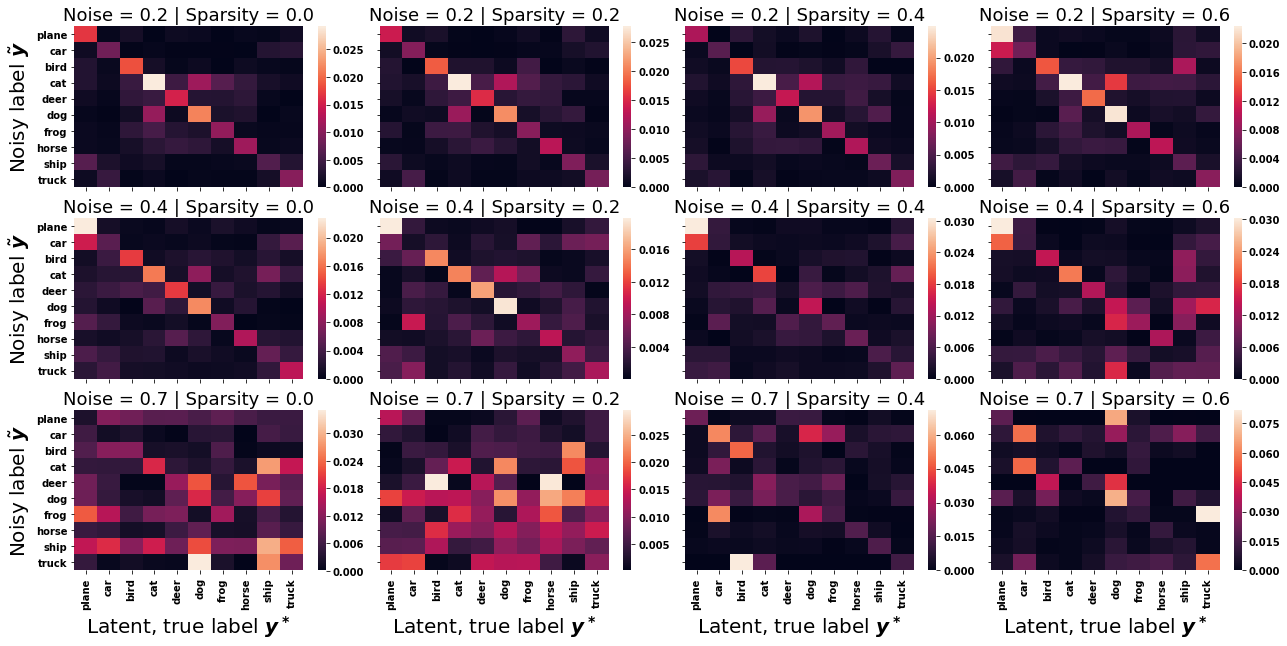

In [9]:
grid = using_multiindex(np.stack(results_argmax), ['Z',  r'Latent, true label $y^*$', r'Noisy label $\tilde{y}$', ])
grid = pd.concat([
    pd.DataFrame(
        [z for z in experiments for i in range(100)],
        columns=['Noise', 'Sparsity'],
    ),
    grid,
], axis=1).drop('Z', axis=1)
fg = sns.FacetGrid(grid, row='Noise', col='Sparsity',aspect=1.5, ) #  height=5, 
g = fg.map_dataframe(draw_heatmap, r'Latent, true label $y^*$', r'Noisy label $\tilde{y}$', 'Absolute Difference', cbar=True)
_ = g.set_titles(size=18)

print('\n\nHEATMAP FOR Baseline estimation of joint\n\n')



CONFIDENT LEARNING estimation of joint




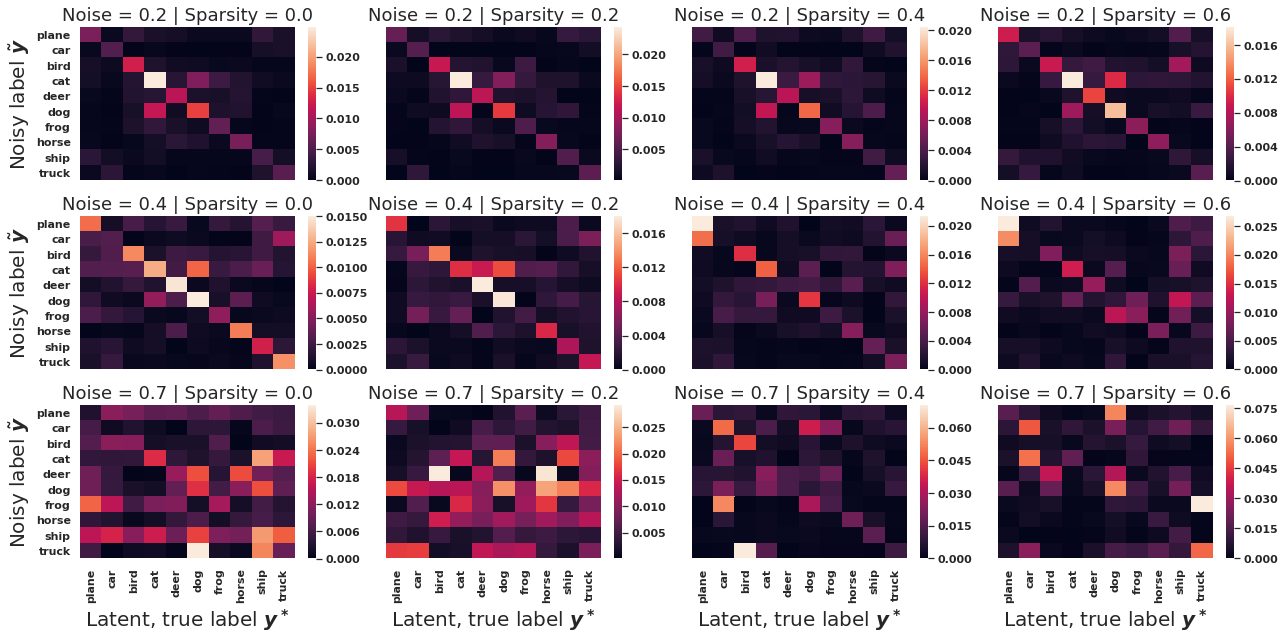

In [47]:
grid = using_multiindex(np.stack(results), ['Z',  r'Latent, true label $y^*$', r'Noisy label $\tilde{y}$', ])
grid = pd.concat([
    pd.DataFrame(
        [z for z in experiments for i in range(100)],
        columns=['Noise', 'Sparsity'],
    ),
    grid,
], axis=1).drop('Z', axis=1)
fg = sns.FacetGrid(grid, row='Noise', col='Sparsity', aspect=1.5, ) #  height=5, 
g = fg.map_dataframe(draw_heatmap, r'Latent, true label $y^*$', r'Noisy label $\tilde{y}$', 'Absolute Difference', cbar=True)
_ = g.set_titles(size=18)
plt.savefig('cifar10_abs_diff_ALL.pdf', bbox_inches='tight', pad_inches=0)
print('\n\nCONFIDENT LEARNING estimation of joint\n\n')

In [11]:
absolute_diff_matrix = results[experiments.index((0.4, 0.6))]
est_joint = est_joints[experiments.index((0.4, 0.6))]
true_joint = true_joints[experiments.index((0.4, 0.6))]

In [58]:
lol = (true_joint - true_joint.diagonal() * np.eye(len(true_joint))).flatten()
lol.sort()
np.cumsum(lol[::-1])

array([0.04369524, 0.08234916, 0.12005343, 0.15214635, 0.18391516,
       0.2115714 , 0.23855549, 0.26067719, 0.28105819, 0.29699572,
       0.31017334, 0.32138446, 0.32948276, 0.33536107, 0.34059212,
       0.34538316, 0.35006719, 0.35443295, 0.35870845, 0.36288368,
       0.36704388, 0.37119521, 0.37522683, 0.37882532, 0.38225382,
       0.38491077, 0.38756095, 0.38976922, 0.39196966, 0.39366796,
       0.39527014, 0.39668905, 0.39807063, 0.39918235, 0.3997912 ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4    

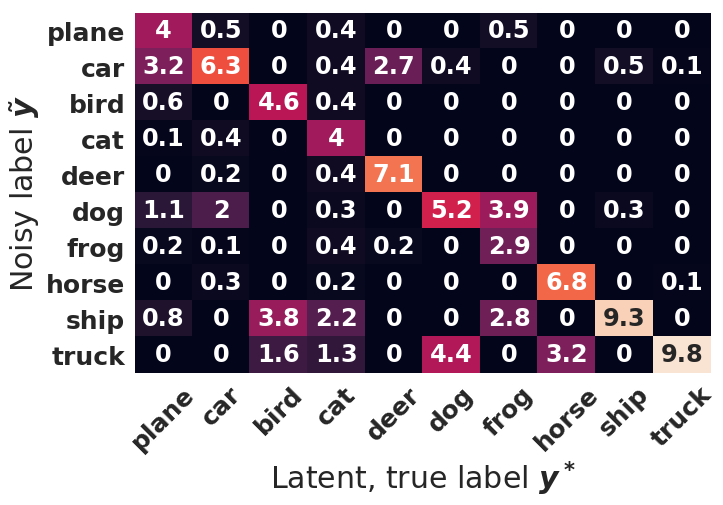

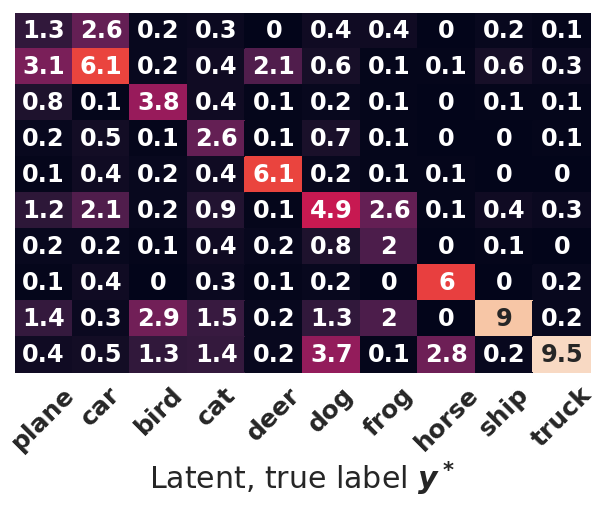

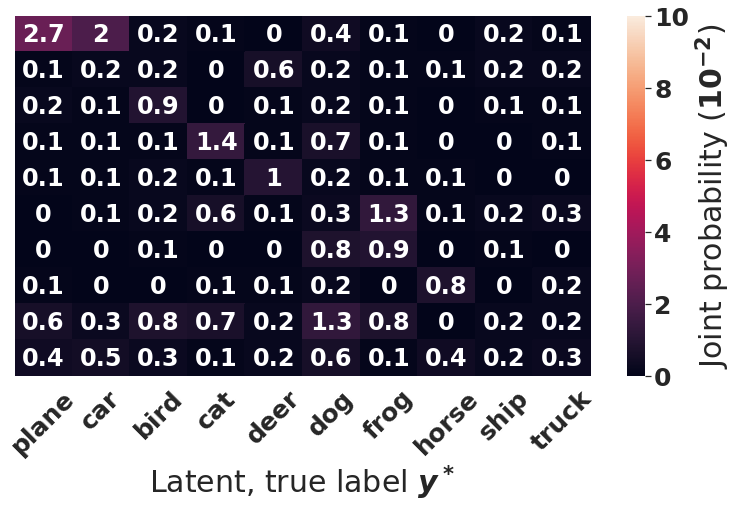

In [102]:
sns.set(font_scale=2)
scale_values = 100
savefig = True

plt.figure(figsize = (8,5))
ax = plt.axes([0., 0., 1., 1.], frameon=False, xticks=[],yticks=[])
ax = sns.heatmap(
    data=pd.DataFrame(true_joint.round(3) * scale_values, columns=cifar10_label_names, index=cifar10_label_names),
    cbar_kws={'label': 'Joint probability'},
    annot=True,
    vmax=0.1 * scale_values,
    cbar=False,
)
_ = ax.set_xlabel(r'Latent, true label $y^*$', fontsize=30)
_ = ax.set_ylabel(r'Noisy label $\tilde{y}$', fontsize=30)
# _ = ax.set_title(r'True joint (unknown to CL) $ \hat{{Q}}_{\tilde{y}, y^*} $', fontsize=30)
# use matplotlib.colorbar.Colorbar object
# cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=13)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 25)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 25)
plt.xticks(rotation=45)
if savefig:
    plt.savefig('cifar10_true_joint_noise_4_sparsity_6.pdf', bbox_inches='tight',
    pad_inches=0)

    
plt.figure(figsize = (8,5))
ax = plt.axes([0., 0., 1., 1.], frameon=False, xticks=[],yticks=[])
ax = sns.heatmap(
    data=pd.DataFrame(est_joint.round(3) * scale_values, columns=cifar10_label_names, index=cifar10_label_names),
    cbar_kws={'label': 'Joint probability'},
    annot=True,
    vmax=0.1 * scale_values,
    cbar=False,
)
_ = ax.set_xlabel(r'Latent, true label $y^*$', fontsize=30)
# _ = ax.set_ylabel(r'Noisy label $\tilde{y}$', fontsize=20)
# _ = ax.set_title(r'CL estimated joint ${Q}_{\tilde{y}, y^*}$', fontsize=30)
# use matplotlib.colorbar.Colorbar object
# cbar = ax.collections[0].colorbar
# here set the labelsize by 20
# cbar.ax.tick_params(labelsize=13)
ax.figure.axes[-1].yaxis.label.set_size(20)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 25)
# ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)
plt.xticks(rotation=45)
plt.yticks([])
if savefig:
    plt.savefig('cifar10_est_joint_noise_4_sparsity_6.pdf', bbox_inches='tight',
    pad_inches=0)

    
plt.figure(figsize = (10,5))
ax = plt.axes([0., 0., 1., 1.], frameon=False, xticks=[],yticks=[])
ax = sns.heatmap(
    data=pd.DataFrame(absolute_diff_matrix.round(3) * scale_values, columns=cifar10_label_names, index=cifar10_label_names),
    cbar_kws={'label': r'Joint probability ($10^{-2}$)'},  # {'label': 'Absolute difference'},
    annot=True,
    vmax=0.1 * scale_values,
)
_ = ax.set_xlabel(r'Latent, true label $y^*$', fontsize=30)
# _ = ax.set_ylabel(r'Noisy label $\tilde{y}$', fontsize=20)
# _ = ax.set_title(r'Absolute difference $ | {Q}_{\tilde{y}, y^*} - \hat{{Q}}_{\tilde{y}, y^*} |$', fontsize=30)
# use matplotlib.colorbar.Colorbar object
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=25)
ax.figure.axes[-1].yaxis.label.set_size(30)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 25)
# ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 14)
plt.xticks(rotation=45)
plt.yticks([])
if savefig:
    plt.savefig('cifar10_abs_diff_noise_4_sparsity_6.pdf', bbox_inches='tight',
    pad_inches=0)